# **Fractal Image Compression using QuadTree Decomposition**
## **Preprocessing e analisi del dataset**

### In questo notebook si vanno a caricare e ad effettuare delle operazioni di preprocessing sulle immagini presenti nel dataset BIWI. Si andrà ad estrarre da ciascuna foto il volto del soggetto in primo piano mediante MediaPipe, effettuando un'analisi sulla loro distribuzione, e si procederà poi con la codifica frattale delle stesse.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 68.4 MB/s 


In [ ]:
import os
from os import path
import cv2
#import mediapipe as mp
import pandas as pd
from dataclasses import dataclass
import re
import math
import matplotlib.pyplot as plt
import numpy as np

Qui vengono definite:
-  la dataclass per rappresentare un'immagine persa;
-  le funzioni che estraggono i valori d'interesse delle immagini applicando una regular expression al nome del file. 

In [ ]:
@dataclass
class LostImage:
  filename: str
  subject: int
  pitch: float
  yaw: float
  roll: float

def extract_values(filename, subject):
  pitch, yaw, roll = [float(x) for x in re.findall("[+-][0-9]+\.[0-9]+", filename)]
  return LostImage(filename, subject, pitch, yaw, roll)


def extract_values_doc(filename):
  subject = re.findall("[0-9]+", filename)[0]
  pitch, yaw, roll = [float(x) for x in re.findall("[+-][0-9]+\.[0-9]+", filename)]
  return LostImage(filename[len(subject):len(filename)], subject, pitch, yaw, roll)

Qui sono definiti tutti i path dove sono localizzati i file utili per il progetto.

In [ ]:
project_path = path.join(os.getcwd(), "drive", "My Drive", "Progetto")
dataset_base_path = path.join(project_path, "dataset")
csv_base_path = path.join(project_path, "CSV")
dataset_path = path.join(dataset_base_path, "biwi_rgb_renamed", "biwi_rgb_renamed")
annotated_path = path.join(dataset_base_path, "dataset_annotated")
cropped_path = path.join(dataset_base_path, "dataset_cropped")
resized_path = path.join(dataset_base_path, "dataset_resized", "resized_128")
file_path = path.join(os.getcwd(), "drive", "My Drive", "Progetto","codice", "lost_doc.txt")


## Face Detection
Questa cella esegue la **face detection** utilizzando **MediaPipe**. <br>
Dall'immagine di partenza costruisce due nuove immagini, la prima con il rettangolo rilevato dall'algoritmo (`annotated_img`), la seconda ritagliata (`cropped_img`).
Infine salva le informazioni relative alle immagini perse in un file `csv`.



In [ ]:
mp_face_detection = mp.solutions.face_detection # Caricamento dell face detection model
mp_drawing = mp.solutions.drawing_utils

lost_imgs = []

with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
  for i in range(1, 25):
    count_lost = 0

    # Per ciascun soggetto all'interno del dataset, viene creata una cartella se questa non esiste
    if not path.exists(path.join(annotated_path, str(i))):
      os.mkdir(path.join(annotated_path, str(i)))
    if not path.exists(path.join(cropped_path, str(i))):
      os.mkdir(path.join(cropped_path, str(i)))
    
    for file in os.listdir(path.join(dataset_path, str(i))):
      image = cv2.imread(path.join(dataset_path, str(i), file))
      
      # Viene applicato il modello di face detection
      results = face_detection.process(image)

      # Se il modello non ha prodotto risultati, 
      # le informazioni relative all'immagine corrente sono aggiunte alla lista delle immagini perse
      if not results.detections:
        count_lost += 1
        lost_imgs.append(extract_values(file, i))
        continue
      
      annotated_img = image.copy()
      crop_img = image.copy()

      # Tra le facce rilevate, viene presa in considerazione solo quella che presenta
      # l'altezza maggiore, ossia la faccia pià vicina all'obiettivo
      max_face = None
      for detection in results.detections:
        if max_face is None or detection.location_data.relative_bounding_box.height > max_face.location_data.relative_bounding_box.height:
          max_face = detection
      
      height, width, channels = image.shape

      # Vengono calcolati i punti estremi del rettangolo della faccia rilevata
      bounding_box = max_face.location_data.relative_bounding_box
      xmin = int(bounding_box.xmin * width)
      ymin = int(bounding_box.ymin * height)
      xmax = int((bounding_box.xmin + bounding_box.width) * width)
      ymax = int((bounding_box.ymin + bounding_box.height) * height)
      
      # Viene disegnato il rettangolo calcolato sull'immagine, e questa viene salvata nel path 'annotated'
      cv2.rectangle(annotated_img, (xmin, ymin), (xmax, ymax), (255, 255, 255), 2)
      cv2.imwrite(path.join(annotated_path, str(i), file), annotated_img)

      # Viene ritagliata l'immagine all'interno del rettangolo, e questa viene salvata nel path 'cropped'
      crop_img = crop_img[ymin:ymax, xmin:xmax]
      cv2.imwrite(path.join(cropped_path, str(i), file), crop_img)
    
    #Per ciascun soggetto, vengono stampate le immagini perse
    print(f"lost for subject {i} are {count_lost}")

# Il file contentente una parte delle immagini perse viene aperto, e vengono lette tutte le linee
with open(file_path,'r') as f:

    line = f.readlines()
# Per ogni linea del file, vengono estratti i valori filename, subject, yaw, pitch e roll e vengono inseriti in 'lost_imgs'
for count in range(0,len(line)):
  lost_imgs.append(extract_values_doc(line[count]))

# I dati relativi alle immagini perse sono esportati in un nuovo file csv
pd.DataFrame(lost_imgs).to_csv(path.join(project_path, "lost.csv"))

lost for subject 1 are 19
lost for subject 2 are 205
lost for subject 3 are 67
lost for subject 4 are 80
lost for subject 5 are 223
lost for subject 6 are 157
lost for subject 7 are 4
lost for subject 8 are 16
lost for subject 9 are 4
lost for subject 10 are 23
lost for subject 11 are 1
lost for subject 12 are 155
lost for subject 13 are 2
lost for subject 14 are 176
lost for subject 15 are 166
lost for subject 16 are 145
lost for subject 17 are 78
lost for subject 18 are 158
lost for subject 19 are 167
lost for subject 20 are 112
lost for subject 21 are 219
lost for subject 22 are 28
lost for subject 23 are 94
lost for subject 24 are 54


### Ridimensionamento
In questa cella sono ridimensionate tutte le immagini ritagliate. <br>
Viene stabilita un'altezza che sarà comune a tutte le foto, pari a `min_height = 128`. <br>
In seguito, viene effettuato il ridimensionamento, mantenendo il ratio originale.

In [ ]:
min_height = 128

for i in range(1, 25):  
  for file in os.listdir(path.join(cropped_path, str(i))):
    # Viene letta l'immagine dal dataset di foto ritagliate
    image = cv2.imread(path.join(cropped_path, str(i), file))
    img_copy = image.copy()
    # Viene salvato il suo ratio originale
    scale = min_height / image.shape[0]    
    w = int(round(image.shape[0] * scale, 0))
    #L'immagine viene ridimensionata con altezza pari a min_height e larghezza proporzionale 
    resized = cv2.resize(img_copy, (w, min_height), interpolation = cv2.INTER_AREA)
    cv2.imwrite(path.join(resized_path, str(i) + '_' + file ), resized)

## Analisi delle immagini perse
Di seguito, si effettua un'analisi grafica sulle informazioni delle immagini per cui non è stato rilevato alcun volto. <br>
<br>
In questa cella viene rappresentato un Barplot, così costruito:
- Asse X = numero del soggetto
- Asse Y = numero di immagini perse

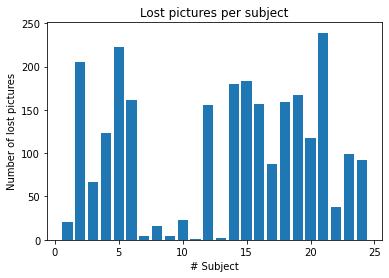

In [ ]:
lost_data = pd.read_csv(path.join(project_path, "lost.csv"))
x = [list(lost_data['subject']).count(i) for i in range(1, 25)]
plt.bar([i for i in range(1, 25)], x)
plt.title('Lost pictures per subject')
plt.xlabel('# Subject')
plt.ylabel('Number of lost pictures')
plt.show()

Si analizzano poi i valori di pitch, yaw e roll delle immagini perse. <br>

**PITCH** è l'angolo di rotazione trasversale della camera. <br>

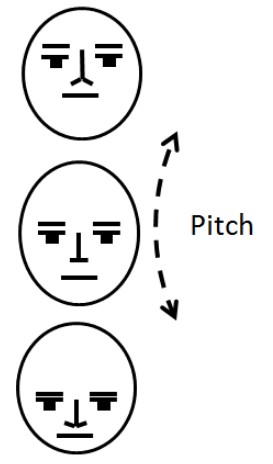

<br>Di seguito, è definito l'istogramma costruito sui valori di pitch delle immagini perse.

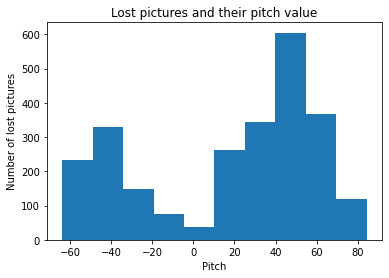

In [ ]:
plt.hist(lost_data['pitch'])
plt.title('Lost pictures and their pitch value')
plt.xlabel('Pitch')
plt.ylabel('Number of lost pictures')
plt.show()

**YAW**  è l'angolo di rotazione orizzontale della camera.

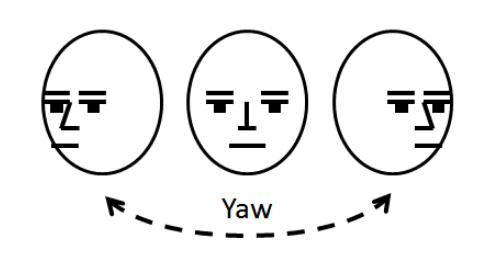

<br>Di seguito, è definito l'istogramma costruito sui valori di yaw delle immagini perse.

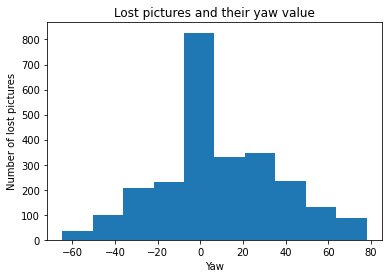

In [ ]:
plt.hist(lost_data['yaw'])
plt.title('Lost pictures and their yaw value')
plt.xlabel('Yaw')
plt.ylabel('Number of lost pictures')
plt.show()

**ROLL** è il valore di rotazione lungo l'asse longitudinale della camera. <br>

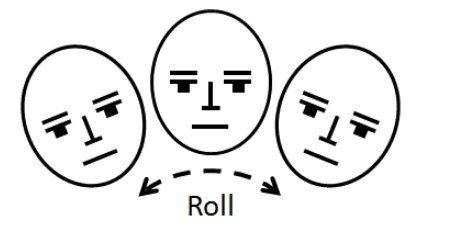

<br>Di seguito, è definito l'istogramma costruito sui valori di roll delle immagini perse.

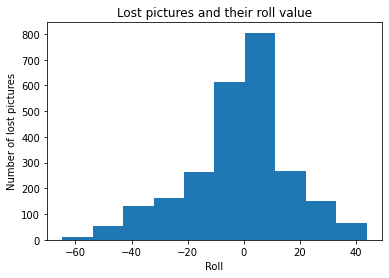

In [ ]:
plt.hist(lost_data['roll'])
plt.title('Lost pictures and their roll value')
plt.xlabel('Roll')
plt.ylabel('Number of lost pictures')
plt.show()

A seguire, viene costruito un istogramma che prenda in considerazione tutti e tre i valori contemporaneamente. <br>
Viene calcolata una somma dei moduli di pitch, yaw e roll e viene raffigurato l'istogramma sotto riportato.

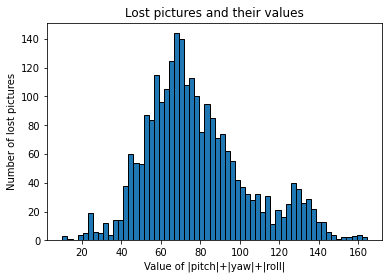

In [ ]:
summed_values = []

for pic in lost_data.iloc:
  current_value = abs(pic.loc['yaw']) + abs(pic.loc['pitch']) + abs(pic.loc['roll'])
  summed_values.append(current_value)

plt.hist(summed_values, bins = 60, edgecolor = 'black')
plt.title('Lost pictures and their values')
plt.xlabel('Value of |pitch|+|yaw|+|roll|')
plt.ylabel('Number of lost pictures')
plt.show()

Al fine di confrontare visivamente le due distribuzioni, lo stesso istogramma viene costruito sulla totalità delle immagini all'interno del dataset originale.

15702


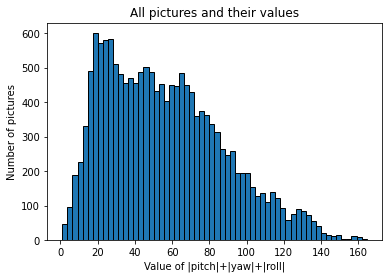

In [ ]:
counter = 0
all_values = []

#Qui viene calcolato il valore di |pitch|+|yaw|+|roll| per tutte le immagini, usando la stessa regex usata per le immagini perse
for i in range(1, 25):
  for file in os.listdir(path.join(dataset_path, str(i))):
      pitch, yaw, roll = [float(x) for x in re.findall("[+-][0-9]+\.[0-9]+", file)]
      sum = abs(pitch) + abs(roll) + abs(yaw)
      all_values.append(sum)

print(len(all_values))

#Viene creato l'istogramma per tutte le immagini
plt.hist(all_values, bins = 60, edgecolor = 'black')
plt.title('All pictures and their values')
plt.xlabel('Value of |pitch|+|yaw|+|roll|')
plt.ylabel('Number of pictures')
plt.show()

## Codifica frattale
Su macchina locale, è stata eseguita la codifica frattale di tutte le foto di cui è stato identificato un volto, e per ciascuna si è ottenuto un file `csv` contenente una matrice rappresentante la relativa codifica. <br>
Il passo successivo è trasformare ciascuna di queste matrici in un array monodimensionale.
<br> Alcune immagini hanno prodotto una matrice nulla, per cui si vuole tenere traccia delle immagini perse per ciascun soggetto.

In [ ]:
# Dataclass per rappresentare una codifica frattale di un'immagine con le relative informazioni
@dataclass
class ArrayImage:
  filename: str
  subject: int  
  pitch: float  
  yaw: float
  roll: float
  array: list
  
# Funzione che dato il CSV generato crea l'array monodimensionale
def get_array_from_csv(file_path):
  generated_array = []

  if(os.path.getsize(file_path) > 1):   
    current_matrix = pd.read_csv(file_path, sep=';', header = None)
    # Si itera sulla matrice e si concatenano tutti gli elementi in un array
    for i in range(current_matrix.shape[0]):
      for j in range(current_matrix.shape[1]):
        generated_array.append(current_matrix.iloc[i, j])

  #print("Generated array of size: " + str(len(generated_array)))
  return generated_array

# Funzione che crea un CSV contenente tutte le immagini con i rispettivi array generati
def generate_arrays_csv():
  array_images = []
  total_count = 0

  for i in range(1, 25):
    count = 0
    dir_name = "out" + str(i)    
    print(f"Generating arrays for subject {i}")
    
    # Viene letta la matrice di una foto e viene generato l'array corrispondente
    for file in os.listdir(path.join(csv_base_path, dir_name)):
      img_path = path.join(csv_base_path, dir_name) + "/" + file
      array = get_array_from_csv(img_path)

      # Se la matrice è nulla, viene aggiunta al conto delle immagini perse per quel soggetto
      if(len(array) < 3):
        count = count + 1
        total_count = total_count + 1

      else:
        # Vengono applicate le regular expression al nome del file per salvare le informazioni sulla foto
        subject = re.findall("[0-9]+", file)[0]
        pitch, yaw, roll = [float(x) for x in re.findall("[+-][0-9]+\.[0-9]+", file)]
        data = ArrayImage(file, subject, pitch, yaw, roll, array)
        array_images.append(data)

    print(f"Null arrays for subject {i} are: {count}")

  print(f"Total lost pictures: {total_count}")
  # Viene creato un nuovo CSV con tutte le immagini non nulle e le relative informazioni
  pd.DataFrame(array_images).to_csv(path.join(project_path, "arrays.csv"))

In [ ]:
generate_arrays_csv()

Generating arrays for subject 1
Null arrays for subject 1 are: 7
Generating arrays for subject 2
Null arrays for subject 2 are: 2
Generating arrays for subject 3
Null arrays for subject 3 are: 8
Generating arrays for subject 4
Null arrays for subject 4 are: 20
Generating arrays for subject 5
Null arrays for subject 5 are: 0
Generating arrays for subject 6
Null arrays for subject 6 are: 16
Generating arrays for subject 7
Null arrays for subject 7 are: 6
Generating arrays for subject 8
Null arrays for subject 8 are: 0
Generating arrays for subject 9
Null arrays for subject 9 are: 15
Generating arrays for subject 10
Null arrays for subject 10 are: 0
Generating arrays for subject 11
Null arrays for subject 11 are: 0
Generating arrays for subject 12
Null arrays for subject 12 are: 2
Generating arrays for subject 13
Null arrays for subject 13 are: 0
Generating arrays for subject 14
Null arrays for subject 14 are: 14
Generating arrays for subject 15
Null arrays for subject 15 are: 35
Generati

Il totale delle foto perse è **266** immagini su 13.178, e non vi sono immagini nulle consecutive per uno stesso soggetto. Si è quindi deciso di scartarle.  

### Studio sulla distribuzione degli array generati

Si vogliono ora osservare i risultati ottenuti dopo aver trasformato in array tutte le codifiche frattali, analizzandone la distribuzione.

In [ ]:
# Funzioni di utilità per leggere dal file CSV gli array e trasformarli da stringa ad array numerici
def count_elements(array):
  i=0
  for element in array:
    if(element == ','):
      i = i+1
  return i+1

def array_from_string(s):
  s = s[1:len(s)-1]
  return [float(x) for x in s.split(',')]

Si caricano gli array dal file su cui erano stati salvati, e si iniziano a stampare le lunghezze per una prima analisi.

In [ ]:
array_data = pd.read_csv(path.join(project_path, "arrays.csv"))

lengths = []

for array in array_data['array']:
  length = count_elements(array)
  if(length > 2):
    lengths.append(length)

print(lengths)

[6060, 6048, 6000, 6048, 5988, 6000, 6036, 6048, 6060, 6012, 6000, 5988, 6012, 6012, 5964, 5916, 6012, 5892, 5880, 5916, 5904, 5580, 5484, 5364, 5208, 5280, 5232, 5376, 5232, 5232, 5136, 5232, 5220, 5280, 5196, 5184, 4944, 4740, 4692, 4476, 4536, 4608, 5016, 4560, 4728, 5208, 4512, 4632, 4404, 4542, 2904, 2904, 4830, 3396, 4164, 3768, 4716, 5160, 4956, 5040, 5052, 4476, 4896, 4764, 4932, 4968, 5028, 5292, 5544, 5340, 5484, 5556, 5136, 5016, 5556, 5580, 5208, 5412, 5628, 5808, 5796, 5676, 5616, 5772, 5856, 5760, 5772, 5772, 5880, 5904, 5820, 5916, 5856, 5724, 5688, 5868, 5784, 5712, 5748, 5868, 5880, 5748, 5556, 5616, 5820, 5712, 5748, 5580, 5712, 5700, 5616, 5544, 5496, 5268, 5328, 5292, 5400, 5172, 5352, 5232, 5316, 5148, 5196, 5232, 5316, 5280, 5316, 5292, 5340, 5244, 5280, 5256, 5256, 5376, 5364, 5424, 5424, 5400, 5544, 5484, 5688, 5784, 5772, 5760, 5736, 5796, 5796, 5820, 5844, 5868, 5892, 5748, 5868, 5880, 5976, 5904, 5964, 6012, 5964, 5976, 5964, 6000, 6036, 6036, 6060, 5988, 591

Mediante la funzione `describe()` si ottiene una tabella che mostra i principali **indici di sintesi** della distribuzione, ossia:
- numero di elementi;
- media;
- deviazione standard;
- quartili.

In [ ]:
from numpy.lib.function_base import median

pd.DataFrame(lengths).describe()

,0
count,12910.000000
mean,4908.176143
std,1029.322077
min,12.000000
25%,4572.000000
50%,5160.000000
75%,5592.000000
max,6144.000000


Viene poi rappresentata graficamente la distribuzione mediante un Boxplot

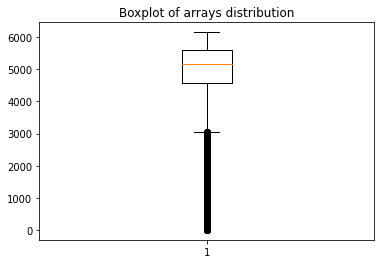

In [ ]:
plt.boxplot(lengths)
plt.title('Boxplot of arrays distribution')
plt.show()

Dal grafico prodotto risulta una distribuzione con una leggera asimmetria, in cui la totalità degli outliers è identificata nella parte inferiore.

In [ ]:
array_data = pd.read_csv(path.join(project_path, "arrays.csv"))

##Autori: Mafalda Ingenito, Ciro Maione, Viviana Pentangelo, Simranjit Singh
###Corso di Fondamenti di Visione Artificiale e Biometria - Prof. M. Nappi
###Toutor: Dott.ssa C. Bisogni, Dott.ssa C. Pero
###Università degli studi di Salerno - Dipartimento di Informatica